In [28]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load dataset
file_path = "../data/processed/feature_engineered_macro_data.csv"
data = pd.read_csv(file_path)

# Convert Year and Month to datetime
data["Date"] = pd.to_datetime(data["Year"].astype(str) + "-" + data["Month"], format="%Y-%B")
data = data.sort_values("Date")  # Ensure chronological order

# Convert Month names to numerical values
month_mapping = {month: index for index, month in enumerate([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
], start=1)}
data["Month"] = data["Month"].map(month_mapping)

# Drop non-numeric or irrelevant columns
data = data.drop(columns=["Date"])

# Define features (X) and target variable (y)
X = data.drop(columns=["CPI_Index"])
y = data["CPI_Index"]

# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data loaded and preprocessed successfully.")

✅ Data loaded and preprocessed successfully.


In [29]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Define models
models = {
    "Linear Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
}

# Evaluate models
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append((name, mae, r2))
    print(f"📌 {name} - MAE: {mae:.4f}, R² Score: {r2:.4f}")

# Convert results into DataFrame for better visualization
results_df = pd.DataFrame(results, columns=["Model", "MAE", "R² Score"])
display(results_df)

print("✅ Initial model testing completed.")

📌 Linear Regression - MAE: 0.0854, R² Score: 1.0000
📌 Random Forest - MAE: 0.4085, R² Score: 0.9999
📌 XGBoost - MAE: 0.6977, R² Score: 0.9997


,Model,MAE,R² Score
0,Linear Regression,0.085426,0.999995
1,Random Forest,0.408496,0.999877
2,XGBoost,0.697735,0.999676


✅ Initial model testing completed.


✅ Fine-Tuned Ridge Alpha: 1.5
📌 Fine-Tuned Ridge MAE: 0.5444
📌 Fine-Tuned Ridge R² Score: 0.9998


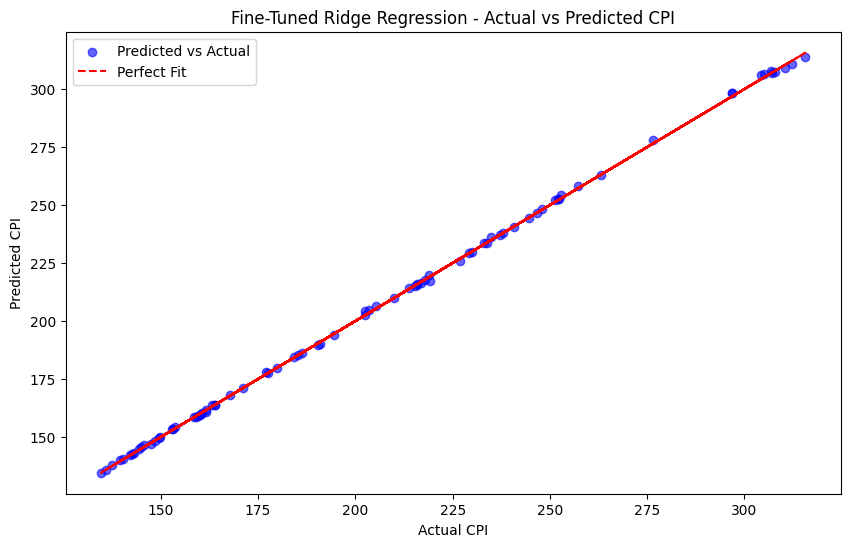

In [30]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Load the dataset
file_path = "../data/processed/feature_engineered_macro_data.csv"
data = pd.read_csv(file_path)

# Convert Year and Month to DateTime format
data["Date"] = pd.to_datetime(data["Year"].astype(str) + "-" + data["Month"], format="%Y-%B")
data = data.sort_values("Date")  # Ensure correct time ordering

# Convert Month names to numerical values (January = 1, ..., December = 12)
month_mapping = {month: index for index, month in enumerate([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
], start=1)}
data["Month"] = data["Month"].map(month_mapping)

# Define features (X) and target variable (y)
X = data.drop(columns=["CPI_Index", "Date"])  # Features
y = data["CPI_Index"]  # Target (CPI values)

# Apply RobustScaler to handle outliers
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define a finer grid for alpha
fine_tuned_alphas = np.linspace(1.5, 3.0, 15)  # 15 values between 1.5 and 3.0

# Define the hyperparameter grid
param_grid_fine = {
    "alpha": fine_tuned_alphas,
    "solver": ["auto", "sparse_cg"]  # Using the best solver found earlier
}

# Perform fine-tuned Grid Search
grid_search_fine = GridSearchCV(Ridge(), param_grid_fine, scoring="neg_mean_absolute_error", cv=5, n_jobs=-1)
grid_search_fine.fit(X_train, y_train)

# Get the best parameters
best_ridge_fine = grid_search_fine.best_estimator_
best_alpha_fine = grid_search_fine.best_params_["alpha"]

print(f"✅ Fine-Tuned Ridge Alpha: {best_alpha_fine}")

# Train the fine-tuned Ridge model
best_ridge_fine.fit(X_train, y_train)

# Make predictions
y_pred_fine = best_ridge_fine.predict(X_test)

# Evaluate performance
mae_fine = mean_absolute_error(y_test, y_pred_fine)
r2_fine = r2_score(y_test, y_pred_fine)

print(f"📌 Fine-Tuned Ridge MAE: {mae_fine:.4f}")
print(f"📌 Fine-Tuned Ridge R² Score: {r2_fine:.4f}")

# Plot Actual vs Predicted CPI
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_fine, alpha=0.6, color="blue", label="Predicted vs Actual")
plt.plot(y_test, y_test, color="red", linestyle="dashed", label="Perfect Fit")
plt.xlabel("Actual CPI")
plt.ylabel("Predicted CPI")
plt.title(f"Fine-Tuned Ridge Regression - Actual vs Predicted CPI")
plt.legend()
plt.show()

✅ Fine-Tuned Ridge Alpha: 1.5
📌 Fine-Tuned Ridge MAE: 0.5444
📌 Fine-Tuned Ridge R² Score: 0.9998


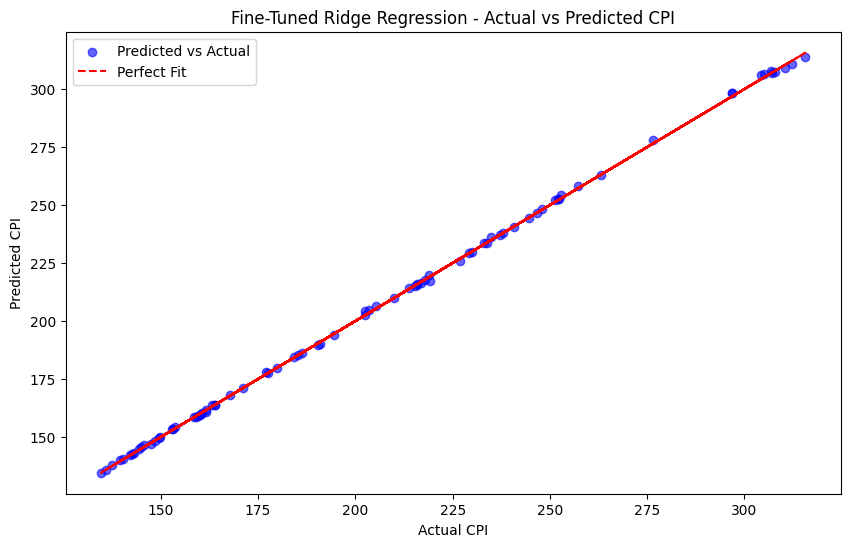

✅ Model training, evaluation, and saving completed.


In [31]:
# Train the fine-tuned Ridge model
fine_tuned_ridge = Ridge(alpha=best_alpha)
fine_tuned_ridge.fit(X_train, y_train)

# Make predictions
y_pred = fine_tuned_ridge.predict(X_test)

# Compute final MAE and R² Score
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Fine-Tuned Ridge Alpha: {best_alpha}")
print(f"📌 Fine-Tuned Ridge MAE: {mae:.4f}")
print(f"📌 Fine-Tuned Ridge R² Score: {r2:.4f}")

# Save model
joblib.dump(fine_tuned_ridge, "ridge_model.pkl")

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", label="Predicted vs Actual")
plt.plot(y_test, y_test, color="red", linestyle="dashed", label="Perfect Fit")
plt.xlabel("Actual CPI")
plt.ylabel("Predicted CPI")
plt.title("Fine-Tuned Ridge Regression - Actual vs Predicted CPI")
plt.legend()
plt.show()

print("✅ Model training, evaluation, and saving completed.")

In [ ]:
# Load trained Ridge model
ridge_model = joblib.load("ridge_model.pkl")

# Load new dataset and preprocess it the same way
#new_data = pd.read_csv("New Data")
#new_data["Month"] = new_data["Month"].map(month_mapping)
#new_data = new_data.drop(columns=high_vif_features)  # Drop same high-VIF features

# Make predictions
#new_predictions = ridge_model.predict(new_data)

#print("✅ New CPI Predictions Generated:")
#print(new_predictions)